In [4]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.signal as sig
import scipy.integrate as sciint
import scipy.interpolate as scinterp
from functools import partial
from scipy import linalg as la
from scipy.spatial import ConvexHull
from itertools import product
import pandas as pd
import pickle as pkl
import os

# Mine
from wilson_cowan_2d.simulations import concrete_wc_kernel as wck
from wilson_cowan_2d.simulations import wc_params as wcp
from wilson_cowan_2d.simulations.nonlinear_functions import decreasing_exponential
from wilson_cowan_2d.analysis.nulclines import calc_cross_points, calc_nulclines_crosspoints
import wilson_cowan_2d.analysis.stability as sta


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
report_path = "/home/nicolasjudd/school_notes/neural/progress_report/"
img_path = os.path.join(report_path, 'img')

In [6]:
def calc_D0(u_bar, v_bar, param):
    bs = calc_bs(param, u_bar, v_bar)
    return (1 - bs[0,0])*(1 + bs[1,1]) + bs[0,1]*bs[1,0]


def calc_bs(param, u_bar, v_bar):
    return param.A * derv_F(param, u_bar, v_bar).reshape(2, 1)


def derv_F(param, u_bar, v_bar):
    ss = ss_F(param, u_bar, v_bar)
    return param.β * ss*(1 - ss)


def ss_F(param, u_bar, v_bar):
    return param.F(param.A[:, 0]*u_bar - param.A[:,1]*v_bar - param.Θ)


def analytic_FT_decexp(σ, ω):
    res = 1/(1 + (σ * ω)**2)
    return res

In [7]:
def calc_Dω_range(param, equib_point, σe, σi_range, point_range=np.linspace(0,100,1_000)):
    bs = calc_bs(param, equib_point[0], equib_point[1])
    e_ft = analytic_FT_decexp(σe, point_range)
    
    return [_Dω_equation(bs, e_ft,analytic_FT_decexp(σi, point_range)) for σi in σi_range]
    

def calc_Dω(param, equib_point, σ, point_range = np.linspace(0,100,1_000)):
    bs = calc_bs(param, equib_point[0], equib_point[1])
    e_ft = analytic_FT_decexp(σ[0], point_range)
    i_ft = analytic_FT_decexp(σ[1], point_range)
    
    return _Dω_equation(bs, e_ft, i_ft)


def _Dω_equation(bs, e_ft, i_ft):
    return (1 - bs[0,0]*e_ft)*(1 + bs[1,1]*i_ft) + bs[0,1]*bs[1,0]*e_ft*i_ft

In [8]:
def fit_ellipse_periodic_orbit(res, N=1_000, period=2*np.pi):
    # Set Fit Parms
    N = 1_000
    u_mean, v_mean = res.u.mean(), res.v.mean()
    t = np.linspace(0, period, N)
    
    # Extract Data
    eu, ev = res.u-u_mean, res.v-v_mean
    U, S, V = la.svd(np.stack((eu.ravel(), ev.ravel())))

    # Fit Ellipse
    unit_circle = np.vstack((np.cos(t), np.sin(t)))
    transform = np.sqrt(2/len(res)) * U.dot(np.diag(S))
    return transform.dot(unit_circle) + np.array([[u_mean], [v_mean]])

In [9]:
def fit_convex_hull(res):
    points = np.concatenate((res.u, res.v), axis=1)
    hull = ConvexHull(points)
    return (points[hull.vertices,0], points[hull.vertices, 1])

def interpolate_hull(u_hull: np.ndarray, v_hull: np.ndarray, prec: int=100) -> np.ndarray:
    points = np.concatenate([(u_hull, v_hull)]).T
    points = np.concatenate([points, points[0].reshape(1,2)], axis=0)

    dists = np.cumsum(np.sqrt(np.sum(np.power(np.diff(points, axis=0),2), axis=1)))
    norm_dists = np.insert(dists, 0, 0)/dists[-1]

    α = np.linspace(0,1,prec)
    interp_test = scinterp.interp1d(norm_dists, points, kind='quadratic', axis=0)
    return interp_test(α).T

In [10]:
τe = 1
τi = 0.5 * τe
σe = 1
σi = 2 * σe
ω = 0.8

In [11]:
ωs = np.linspace(0, 1, 10)
σs = τs = np.linspace(0.5,1,21)

In [12]:
output = list()

# for ix, (ω, σ) in enumerate(product(ωs, σs)):
#     τ = 0.45
#     τe = 1
#     τi = τ * τe
#     σe = 1
#     σi = σ * σe

param = wcp.DefaultParams(τ = np.array([τe, τi]).reshape(2,1), η = 1, size = 1)

    

In [233]:
# param.Θ = np.array([0.08, 0.4])

    inp = np.array([0.4, 0.2]).reshape(2,1)

    test = wck.WCUnif(inp, param)
    end = 10
    ures = test((0, end), t_eval=np.arange(0, end, 0.1))
    u_hull, v_hull = fit_convex_hull(ures)
    u_hull, v_hull = interpolate_hull(u_hull, v_hull, prec=100)

    # u,v,cps = calc_nulclines_crosspoints(param)
    # _ = plt.plot(*u)
    # _ = plt.plot(*v)
    # _ = plt.scatter(*cps, c='r')
    # _ = plt.xlim(-0.1, 0.5)
    # _ = plt.ylim(-0.1, 0.5)
    # print(cps)
    # _ = plt.plot(res.u, res.v)
    # # plt.plot(*fit_periodic_orbit(res), 'r')
    # plt.plot(u_hull, v_hull, 'b')

    def update(t, X, param, u_hull, v_hull, σe, σi, τe, τi, ω):
        t = int(100*t) % len(u_hull)
        X = X.reshape(2,2)
        A = sta.calc_AA(param, u_hull[t], v_hull[t], σe, σi, τe, τi, ω)

        return (A @ X).ravel()


    end = 100*(len(u_hull))
    res = sciint.solve_ivp(update, (0,end), np.eye(2).ravel()
                           , args=(param, u_hull, v_hull, σe, σi, τe, τi, ω),
                             t_eval=range(end),first_step = 1, max_step = 1)

    M = res.y.T[-1].reshape(2,2)
    Q = 1 + la.det(M) + np.trace(M)
    break
    if not res.success or ix % 522-1 == 1:
        
        clear_output(wait=True)
        if not res.success: break
        
        print(res.message)
        print(f"On iter: {ix: >6}, params <- σ:{σ:>0.2}, τ:{τ:>0.2}, ω:{ω:>0.2}, Q:{Q:>0.2}") 

    output.append({"σ":σ, "τ":τ, "ω":ω, "Q":Q})

/tmp/ipykernel_737603/243202773.py:37: RuntimeWarning: invalid value encountered in matmul
  return (A @ X).ravel()


In [300]:
ωs = np.linspace(0.5, 1.2, 19)
σs = τs = np.linspace(0.5,2.5,21)

In [14]:
b  =sta.calc_bs(param, np.array(0.4), np.array(0.2), derv=sta.derv_F)

(1 + b[1,1])/(b[0,0] - 1)

0.24509964628418868

In [ ]:
prec = 10
output = list()

for ix, (ω, σ) in enumerate(product(ωs, σs)):
    τ = 0.5
    τe = 1
    τi = τ * τe
    σe = 1
    σi = σ * σe

    param = wck.DefaultParams(τ = np.array([τe, 1/τi]).reshape(2,1), η = 1, size = 1)
    param.Θ = np.array([0.08, 0.4])

    inp = np.array([0.4, 0.2]).reshape(2,1)

    test = wck.WCUnif(inp, param)
    end = 10
    ures = test((0, end), t_eval=np.arange(0, end, 0.1))
    u_hull, v_hull = fit_convex_hull(ures)
    u_hull, v_hull = interpolate_hull(u_hull, v_hull, prec=prec)

    X = np.eye(2)
    for (u, v) in zip(u_hull, v_hull):
        A = sta.calc_AA(param, u, v, σe, σi, τe, τi, ω)
        X += 1/prec * A @ X

    # X += 1/prec * sta.calc_AA(param, u_hull[0], v_hull[0], σe, σi, τe, τi, ω) @ X
    
    Q = 1 + la.det(X) + np.trace(X)
    
    del X
    if ix % 522-1 == 1:
        clear_output(wait=True)
        print(f"On iter: {ix: >6}, params <- σ:{σ:>0.2}, τ:{τ:>0.2}, ω:{ω:>0.2}, Q:{Q:>0.2}") 

    output.append({"σ":σ, "τ":τ, "ω":ω, "Q":Q})

out = pd.DataFrame(output)

σ    0.800000
τ    0.500000
ω    0.500000
Q   -1.376202
dtype: float64

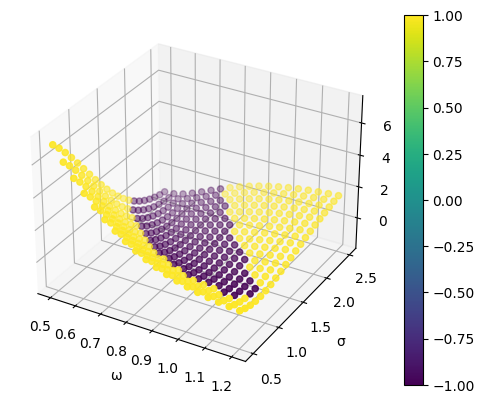

In [352]:
out.loc[lambda x: x.Q < 0].min(axis=0)

ax = plt.figure().add_subplot(projection='3d')

im = ax.scatter(out.ω, out.σ, np.sign(out.Q)*(np.abs(out.Q)), c=np.sign(out.Q))
_ = ax.set_ylabel('σ')
_ = ax.set_xlabel('ω')
_ = ax.set_zlabel('Q')

_ = plt.colorbar(im)

In [754]:
output_saves = {}

2.1249097430062394

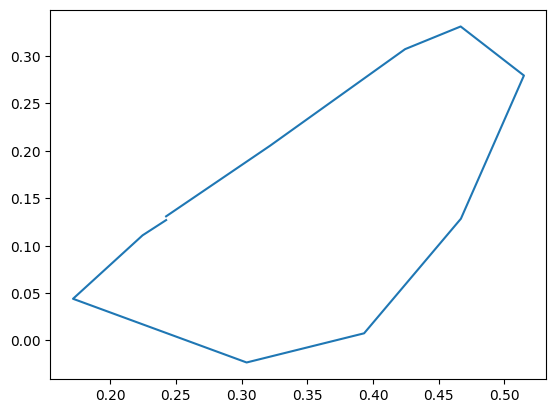

In [988]:
output = list()
ωs = np.arange(0.1, 2.5, 0.01)
σs = τs = np.arange(0.1, 2.5, 0.01)  # np.linspace(0.5,2.5,21)

τ = 0.65
τe = 1
τi = τ * τe


param = wck.DefaultParams(τ = np.array([τe, 1/τi]).reshape(2,1), η = 1, size = 1)
# param.Θ = np.array([0.08, 0.4])

inp = np.array([0.4, 0.2]).reshape(2,1)

test = wck.WCUnif(inp, param)
end = 10
ures = test((0, end), t_eval=np.arange(0, end, 0.01)) 
uv_init = ures._solved.y.T[-1].reshape(2,1)

# Find Period
def find_period_func(T):
    start = wck.WCUnif(uv_init, param)
    res = start((0,T),simple=True, t_eval=(0,T))
    return np.sum(np.abs(uv_init - res.y.T[-1].reshape(2,1)))  # , res

period = opt.fsolve(find_period_func, 2.5)[0]

period

test = wck.WCUnif(uv_init, param)
new_res = test((0,period), simple=True)

new_u, new_v = new_res.y
_=  plt.plot(new_u, new_v)

In [989]:
for ix, (ω, σ) in enumerate(product(ωs, σs)):
    σe = 1
    σi = σ * σe

    # Find Mondronomy Matrix
    def update(t, inp, param, σe, σi, τe, τi, ω):
        X  = inp[0:4].reshape(2,2)
        u, v = inp[4:]

        A = param.A   # To subtract ends
        F = param.F
        Θ = param.Θ
        τ = param.τ
        AA = sta.calc_AA(param, u, v, σe, σi, τe, τi, ω)
        # print(AA, u, v, t)

        dX = (AA @ X).ravel()
        du = F(A[0,0]*u - A[0,1]*v - Θ[0]) - u
        dv = (F(A[1,0]*u - A[1,1]*v - Θ[1]) - v)/τi
        
        # print(X, t)

        return _make_inp(dX, np.array([du, dv]))

    def _make_inp(X, uv):
        return np.concatenate((X.ravel(), uv.ravel()))

    new_res = sciint.solve_ivp(update, (0, period), _make_inp(np.eye(2).ravel(), uv_init)
                               , args=(param, σe, σi, τe, τi, ω))


    # Calc Q
    X = new_res.y[:4].T[-1].reshape(2,2)
    Q = 1 + np.trace(X) + la.det(X)
    
    if ix % 222-1 == 1:
        clear_output(wait=True)
        print(f"On iter: {ix: >6}, params <- σ:{σ:>0.2}, τ:{τ:>0.2}, ω:{ω:>0.2}, Q:{Q:>0.2}") 

    output.append({"σ":σ, "τ":τ, "ω":ω, "Q":Q})

On iter:  57500, params <- σ:1.5, τ:0.65, ω:2.5, Q:1.2


In [990]:
out = pd.DataFrame(output)
output_saves[τ] = out
out.loc[lambda x: x.Q < 0].min(axis=0)

σ    0.100000
τ    0.650000
ω    0.100000
Q   -5.286225
dtype: float64

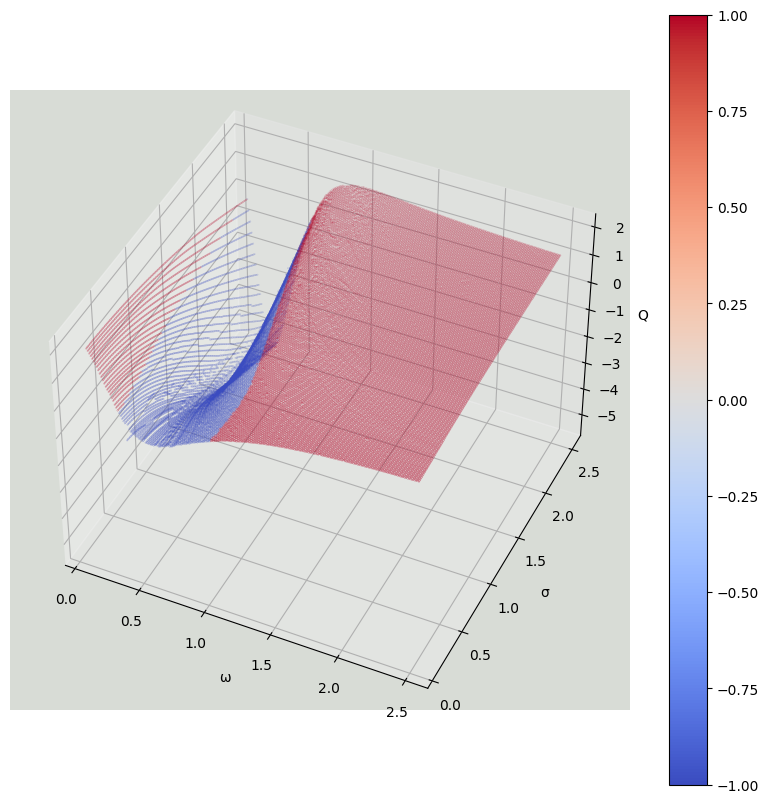

In [991]:
fig_name = f"linear_stability_tau-{τ}.png"
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

im = ax.scatter(out.ω, out.σ, np.sign(out.Q)*(np.abs(out.Q)), c=np.sign(out.Q)
                , s=0.02, cmap=cm.coolwarm)
_ = ax.set_ylabel('σ')
_ = ax.set_xlabel('ω')
_ = ax.set_zlabel('Q')

ax.set_facecolor('xkcd:light gray')
ax.view_init(42, -65)

_ = plt.colorbar(im)

# plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')

In [992]:
from matplotlib import cm

In [993]:
out.min()

σ    0.100000
τ    0.650000
ω    0.100000
Q   -5.286225
dtype: float64

In [994]:
out.loc[lambda x: x.ω == 0.10]

,σ,τ,ω,Q
0,0.10,0.65,0.1,1.940054
1,0.11,0.65,0.1,1.939346
2,0.12,0.65,0.1,1.938571
3,0.13,0.65,0.1,1.937729
4,0.14,0.65,0.1,1.936819
...,...,...,...,...
235,2.45,0.65,0.1,0.051369
236,2.46,0.65,0.1,0.037187
237,2.47,0.65,0.1,0.022979
238,2.48,0.65,0.1,0.008745


In [995]:
out.iloc[0].Q

1.9400537262007187

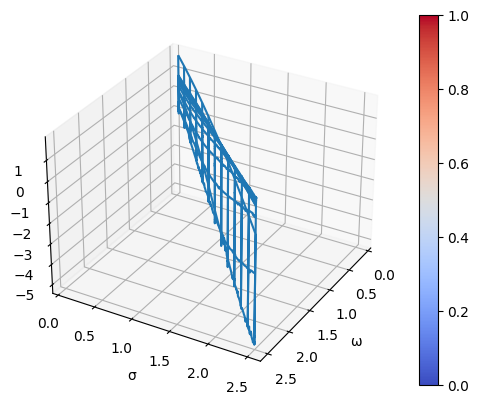

In [996]:
fig_name = f"linear_stability_tau-{τ}"
ax = plt.figure().add_subplot(projection='3d')

im = ax.plot_wireframe(np.array(out.ω.unique())
                     , np.array(out.σ.unique())
                     , np.array(out.Q).reshape(240,240)
                     , cmap=cm.coolwarm
                     ,rstride=20, cstride=20)
_ = ax.set_ylabel('σ')
_ = ax.set_xlabel('ω')
_ = ax.set_zlabel('Q')

ax.view_init(30, 30)

_ = plt.colorbar(im)

# plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')

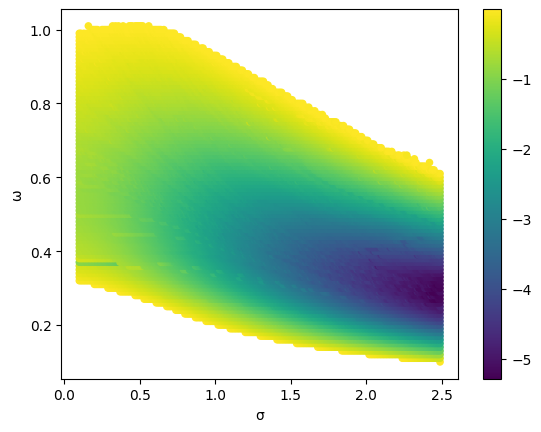

In [997]:
fig_name = f"linear_stability_negitive_projection_tau-{τ}.png"
dat = out.loc[lambda x: x.Q <0][['ω', 'σ', 'Q']]
_ = plt.scatter(dat.σ, dat.ω, s=20, cmap=cm.viridis, c=dat.Q)
_ = plt.xlabel("σ")
_ = plt.ylabel("ω")
_ = plt.colorbar()

# plt.facecolor('xkcd:light gray')

plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')

In [1017]:
data = output_saves[0.3]

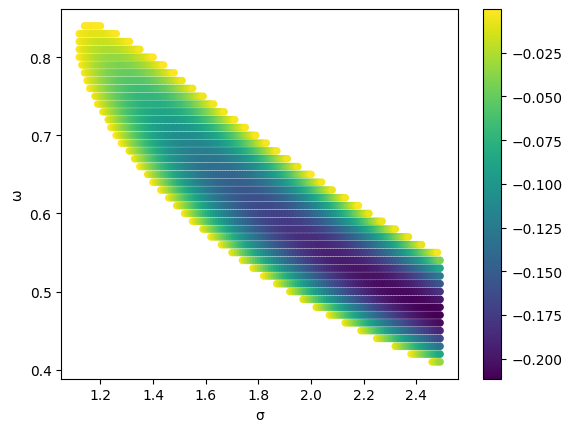

In [1018]:
fig_name = f"linear_stability_negitive_projection_tau-{τ}.png"
dat = data.loc[lambda x: x.Q <0][['ω', 'σ', 'Q']]
_ = plt.scatter(dat.σ, dat.ω, s=20, cmap=cm.viridis, c=dat.Q)
_ = plt.xlabel("σ")
_ = plt.ylabel("ω")
_ = plt.colorbar()

# plt.facecolor('xkcd:light gray')

plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')

In [817]:
x = pd.concat(output_saves, axis=0)

In [819]:
# import pickle as pkl

# with open("output_saves_125-040.pkl",'wb') as w:
#     pkl.dump(x, w)

In [999]:
vv = list()
for k,v in output_saves.items():
    uu = v.loc[lambda x: x.Q < 0]
    min_σ = uu.σ.min()
    vv.append(uu.loc[lambda x: x.σ == min_σ].loc[lambda x: x.ω == x.ω.min()])

In [1000]:
test = pd.concat(vv)

In [1001]:
test = test.sort_values(by="τ")

In [1002]:
test

,σ,τ,ω,Q
14798,1.68,0.250,0.71,-0.000297
16902,1.12,0.300,0.80,-0.001156
16644,0.94,0.350,0.79,-0.001208
16608,0.58,0.500,0.79,-0.000833
16080,0.10,0.550,0.77,-0.003100
12960,0.10,0.575,0.64,-0.026061
5280,0.10,0.650,0.32,-0.035324


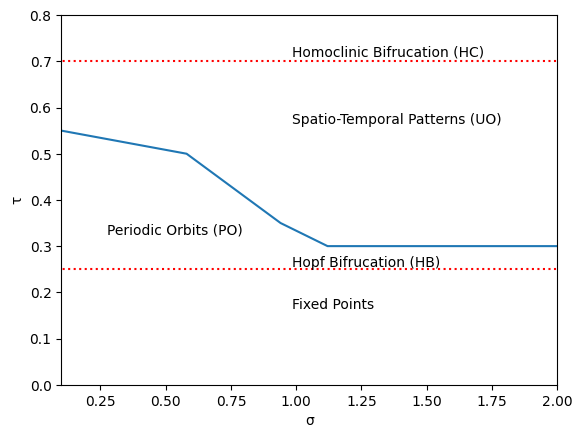

In [1082]:
dat = test.loc[lambda x: x.τ <0.575].loc[lambda x: x.τ >0.28]
dat = pd.concat((dat, pd.DataFrame([{'τ': 0.3, 'σ': 2, 'ω':0.1,'Q': 0}])))
dat = dat.sort_values('σ')


_ = plt.plot(dat.σ, dat.τ)
_ = plt.xlabel("σ")
_ = plt.ylabel("τ")
_ = plt.xlim(0.1, 2)
_ = plt.ylim(0, 0.8)

_ = plt.hlines(0.7 , xmin=0, xmax=10, linestyle = ":", color='r')
_ = plt.hlines(0.25, xmin=0, xmax=10, linestyle = ":", color='r')


_ = plt.text(0.5, 0.2, f"Fixed Points",fontsize=10
             ,ha='left', va='bottom', transform=ax.transAxes)

_ = plt.text(0.0, 0.4, f"Periodic Orbits (PO)",fontsize=10
             ,ha='left', va='bottom', transform=ax.transAxes)

_ = plt.text(0.5, 0.7, f"Spatio-Temporal Patterns (UO)",fontsize=10
             ,ha='left', va='bottom', transform=ax.transAxes)

_ = plt.text(0.5, 0.92, f"Homoclinic Bifrucation (HC)",fontsize=10
             ,ha='left', va='top', transform=ax.transAxes)

_ = plt.text(0.5, 0.35, f"Hopf Bifrucation (HB)",fontsize=10
             ,ha='left', va='top', transform=ax.transAxes)

fig_name = f"linear_stability_sig_lt_2.png"
plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')

In [537]:
start = wck.WCUnif(uv_init, param)
T = guess[0]
res = start((0,T),simple=True)

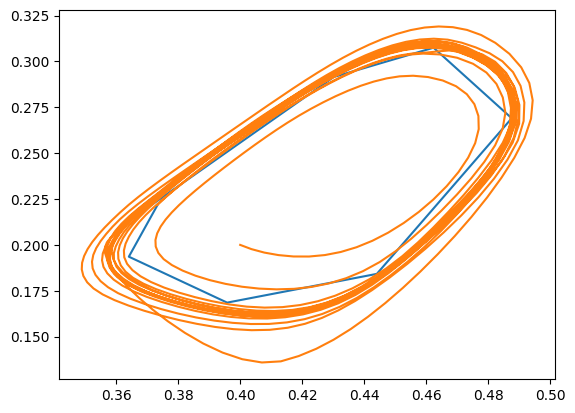

In [538]:
_ = plt.plot(res.y[0], res.y[1])
_ = plt.plot(ures.u, ures.v)

In [539]:
uv_init

array([[0.37338519],
       [0.22186019]])

In [393]:
res

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.007e+01]
        y: [[ 3.734e-01  3.746e-01]
            [ 2.219e-01  2.219e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 776
     njev: 0
      nlu: 0

In [ ]:
54.96709998

In [379]:
uuvv = find_period_func(20)

In [372]:
res._solved

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0 20]
        y: [[ 3.734e-01  4.190e-01]
            [ 2.219e-01  2.815e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1532
     njev: 0
      nlu: 0

In [ ]:
    X = np.eye(2)
    for (u, v) in zip(u_hull, v_hull):
        A = sta.calc_AA(param, u, v, σe, σi, τe, τi, ω)
        X += 1/prec * A @ X

    # X += 1/prec * sta.calc_AA(param, u_hull[0], v_hull[0], σe, σi, τe, τi, ω) @ X
    
    Q = 1 + la.det(X) + np.trace(X)
    
    del X
    if ix % 522-1 == 1:
        clear_output(wait=True)
        print(f"On iter: {ix: >6}, params <- σ:{σ:>0.2}, τ:{τ:>0.2}, ω:{ω:>0.2}, Q:{Q:>0.2}") 

    output.append({"σ":σ, "τ":τ, "ω":ω, "Q":Q})

out = pd.DataFrame(output)

/home/nicolasjudd/school_notes/neural/py_projs/2D_wilson_cowan/src/wilson_cowan_2d/systems/concrete_wc_kernel.py:24: RuntimeWarning: overflow encountered in exp
  return 1/(1 + nexp(-self.β * other))


[[0.         0.438     ]
 [0.00394604 0.24293359]]


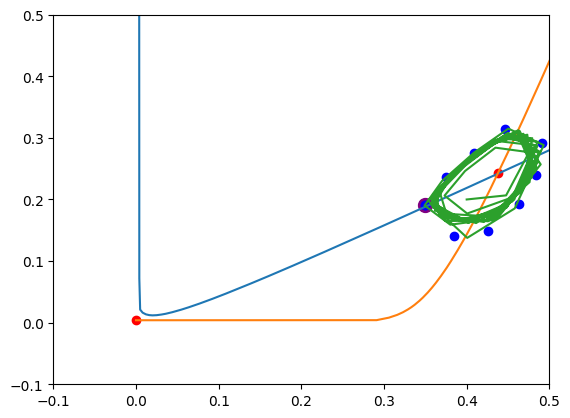

In [218]:
u,v,cps = calc_nulclines_crosspoints(param)
_ = plt.plot(*u)
_ = plt.plot(*v)
_ = plt.scatter(*cps, c='r')
_ = plt.xlim(-0.1, 0.5)
_ = plt.ylim(-0.1, 0.5)
print(cps)
_ = plt.plot(ures.u, ures.v)
_ = plt.scatter(u_hull[-1], v_hull[-1], s=100, c='purple')
# plt.plot(*fit_periodic_orbit(res), 'r')
plt.scatter(u_hull, v_hull, c='b')

In [1430]:
Qs = list()
reses = list()

ωs = np.arange(0.1, 2.5, 0.1)
for ω in ωs:
    param = wck.MondronomyParams(τ = np.array([1, 0.5]), η = 1, size = 1, ω = ω)
    param.Θ = np.array([0.8, 0.4])
    σ = np.array([1, 0.8])
    X = np.eye(2).ravel()
    uv = np.array([0.424, 0.2047]).ravel()
    inp = np.concatenate((X, uv))
    # inp = X.ravel()

    mond = wck.WCDecExpMondronomy(inp, param, σ)

    # ω = 0.6
    final_time = 20
    rang = np.arange(0, final_time, 0.1)
    res = mond((0,final_time), t_eval=rang)
    reses.append(res)

    M = res._solved.y[0:4, :].T[np.where(np.round(res._solved.t, 1) == 5.9)].reshape(2,2)
    
    Qs.append(1 + np.trace(M) + np.linalg.det(M))

In [839]:
ix = 5

la.eig(reses[ix]._solved.y[0:4, :].T[-1].reshape(2,2))
ωs[ix]

(array([3.83188489e-07+0.j, 9.78104495e-11+0.j]),
 array([[7.37453729e-02, 1.02667030e-14],
        [9.97277103e-01, 1.00000000e+00]]))

0.6

In [840]:
# bs = wck.calc_bs(param, uv[0], uv[1])
# AA = wck._calc_AA(param.ω, bs, *σ, *param.τ)

# AA@np.eye(2)

In [841]:
fftout = np.fft.rfft(reses[ix]._solved.y[4,:].T)
freqs = np.fft.rfftfreq(reses[ix]._solved.y[4,:].size, d=0.1)

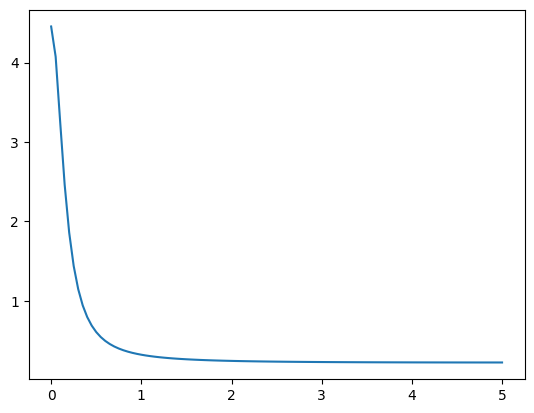

In [842]:
_=plt.plot(freqs[np.where(fftout.real<10)], fftout.real[np.where(fftout.real<10)])

In [843]:
1/freqs[np.where(np.abs(fftout.real)>2)][1:]

array([20.        , 10.        ,  6.66666667])

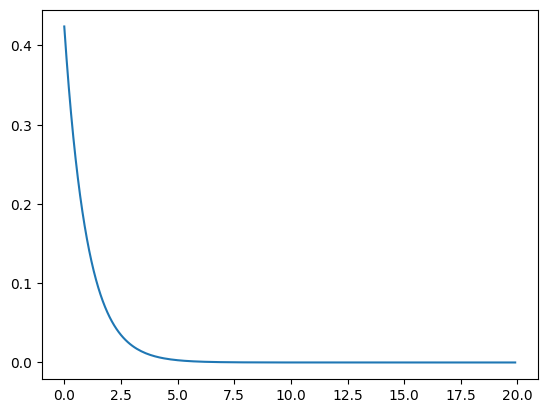

In [844]:
_ = plt.plot(reses[ix]._solved.t, reses[ix]._solved.y[4,:].T)

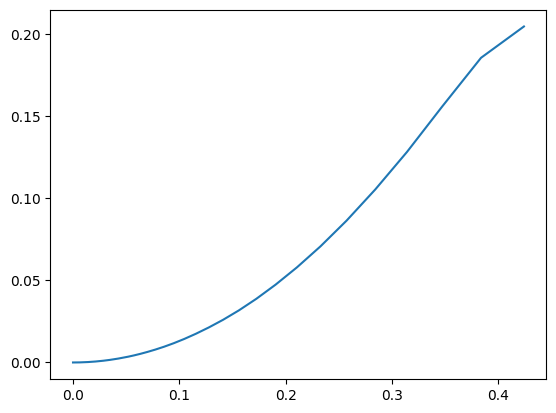

In [845]:
_ = plt.plot(reses[ix]._solved.y[4,:].T, reses[ix]._solved.y[5,:].T)

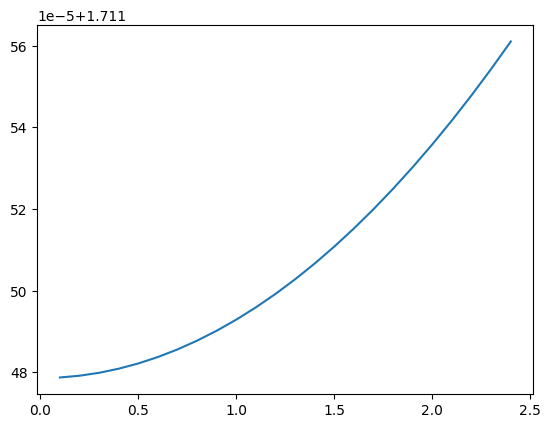

In [846]:
_ = plt.plot(ωs, Qs)

In [847]:
Qs

[1.711478697537415,
 1.7114791274933512,
 1.7114798440796495,
 1.7114808472859182,
 1.7114821370976099,
 1.7114837134960201,
 1.7114855764582906,
 1.711487725957408,
 1.7114901619622072,
 1.7114928844373687,
 1.7114958933434246,
 1.7114991886367545,
 1.7115027702695909,
 1.7115066381900221,
 1.7115107923419883,
 1.711515232665287,
 1.7115199590955785,
 1.7115249715643788,
 1.711530269999073,
 1.7115358543229102,
 1.711541724455006,
 1.7115478803103514,
 1.7115543217998102,
 1.7115610488301247]